### Objective:
 Ensure the data in the gold_features table is accurate, consistent, complete, and ready for downstream analysis or modeling.

In [0]:
df_features = spark.table("bitcoin.market_data.features_bitcoin")

In [0]:
from pyspark.sql.functions import col, sum

# Count nulls per column
df_features.select([sum(col(c).isNull().cast("int")).alias(c + "_nulls") for c in df_features.columns]).show()


+-----------------+-----------+----------+---------+----------+------------+----------+-----------+----------------+----------------------+--------------------------+
|market_date_nulls|close_nulls|high_nulls|low_nulls|open_nulls|volume_nulls|year_nulls|month_nulls|prev_close_nulls|daily_change_pct_nulls|rolling_avg_close_7d_nulls|
+-----------------+-----------+----------+---------+----------+------------+----------+-----------+----------------+----------------------+--------------------------+
|                0|          0|         0|        0|         0|           0|         0|          0|               1|                     1|                         0|
+-----------------+-----------+----------+---------+----------+------------+----------+-----------+----------------+----------------------+--------------------------+



In [0]:
df_features.printSchema()

root
 |-- market_date: date (nullable = true)
 |-- close: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- open: double (nullable = true)
 |-- volume: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- prev_close: double (nullable = true)
 |-- daily_change_pct: double (nullable = true)
 |-- rolling_avg_close_7d: double (nullable = true)



In [0]:
df_features.groupBy("market_date").count().filter("count > 1").show()

+-----------+-----+
|market_date|count|
+-----------+-----+
+-----------+-----+



In [0]:
df_features.selectExpr(
    "min(close)", "max(close)", 
    "min(volume)", "max(volume)", 
    "min(daily_change_pct)", "max(daily_change_pct)"
).show()


+------------------+--------------+-----------+------------+---------------------+---------------------+
|        min(close)|    max(close)|min(volume)| max(volume)|min(daily_change_pct)|max(daily_change_pct)|
+------------------+--------------+-----------+------------+---------------------+---------------------+
|178.10299682617188|119995.4140625|    5914570|350967941479|               -37.17|                25.25|
+------------------+--------------+-----------+------------+---------------------+---------------------+



<Axes: >

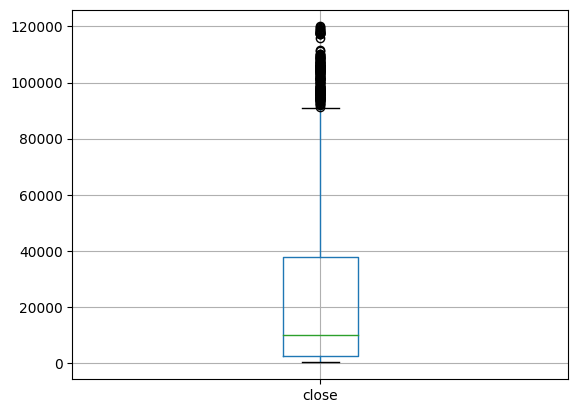

In [0]:
df_features.select("close").toPandas().boxplot()


In [0]:
# Assuming daily data is expected
from pyspark.sql.functions import to_date, datediff, lag
from pyspark.sql.window import Window

df_dates = df_features.select("market_date").distinct().orderBy("market_date")
df_dates = df_dates.withColumn("prev_date", lag("market_date").over(Window.orderBy("market_date")))
df_dates = df_dates.withColumn("day_gap", datediff("market_date", "prev_date"))
df_dates.filter("day_gap > 1").show()


/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


+-----------+---------+-------+
|market_date|prev_date|day_gap|
+-----------+---------+-------+
+-----------+---------+-------+



In [0]:
df_features.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("bitcoin.market_data.verified_features")

In [0]:
import dlt
from pyspark.sql.functions import col

@dlt.table(
    name="verified_features_data",
    comment="Verified feature table with quality checks"
)
def validate_features():
    df = dlt.read("feature_bitcoin_data")

    # Example quality check: drop rows where daily change is null
    df_verified = df.filter(col("daily_change_pct").isNotNull())

    return df_verified


The Delta Live Tables (DLT) module is not supported on this cluster.
 You should either create a new pipeline or use an existing pipeline to run DLT code.

The Delta Live Tables (DLT) module is not supported on this cluster.
 You should either create a new pipeline or use an existing pipeline to run DLT code.

---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
File <command-4927979449718657>, line 1
----> 1 import dlt
      2 from pyspark.sql.functions import col
      4 @dlt.table(
      5     name="verified_features_data",
      6     comment="Verified feature table with quality checks"
      7 )
      8 def validate_features():

File /databricks/python_shell/lib/dbruntime/autoreload/discoverability/hook.py:71, in AutoreloadDiscoverabilityHook._patched_import(self, name, *args, **kwargs)
     65 if not self._should_hint and (
     66     (module := sys.modules.get(absolute_name)) is not None and
     67     (fname := get_allowed_file_name_or_none(module)) is not None and
     68     (mtime := os.stat(fname).st_mtime) > self.last_mtime_by_modname.get(
     69         absolute_name, float("inf")) and not self._should_hint):
     70     self._should_hint = True
---> 71 module = self._original_